# Hyperbolic Busemann Learning with Ideal Prototypes

Welcome to our third notebook for the ECCV 2022 Tutorial "[Hyperbolic Representation Learning for Computer Vision](https://sites.google.com/view/hyperbolic-tutorial-eccv22)"!


**Open notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/MinaGhadimiAtigh/hyperbolic_representation_learning/blob/main/notebooks/3_Hyperbolic_Busemann_Learning_with_Ideal_prototypes.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MinaGhadimiAtigh/hyperbolic_representation_learning/blob/main/notebooks/3_Hyperbolic_Busemann_Learning_with_Ideal_prototypes.ipynb)    

**Authors:** Mina Ghadimi Atigh

In this notebook, you will go through [Hyperbolic Busemann Learning with Ideal prototypes](https://proceedings.neurips.cc/paper/2021/file/01259a0cb2431834302abe2df60a1327-Paper.pdf), NeurIPS 2021 paper. The code is available in [Github](https://github.com/MinaGhadimiAtigh/Hyperbolic-Busemann-Learning). 

Building on the success of deep learning with prototypes in Euclidean and hyperspherical spaces, a few recent works have proposed hyperbolic prototypes for classification. Such approaches enable effective learning in low-dimensional output spaces and can exploit hierarchical relations amongst classes, but require privileged information about class labels to position the hyperbolic prototypes. This paper strives to combine the best of both non-Euclidean worlds, namely efficient low-dimensional embeddings from hyperbolic prototypes and the knowledge-free positioning from hyperspherical prototypes.

The paper makes three contributions. First, introduces a hyperbolic prototype network with
class prototypes given as points on the ideal boundary of the Poincaré ball model of hyperbolic
geometry. Second, proposes the penalized Busemann loss, which enables us to compute proximities
between example outputs in hyperbolic space and prototypes at the ideal boundary, an impossible
task for existing distance metrics, which put the ideal boundary at infinite distance from all other points in hyperbolic space. Third, we provide a theoretical link between our hyperbolic prototype approach and logistic regression.

Let's start with importing the libraries and setting manual seed using `set_seed`.

In [1]:
## standard libraries
import math
import numpy as np
from PIL import Image
import warnings

## Imports for plotting
import matplotlib
import matplotlib.pyplot as plt

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## PyTorch Torchvision
import torchvision
from torchvision import datasets, transforms

warnings.filterwarnings('ignore')

In [2]:
!wget -q https://raw.githubusercontent.com/MinaGhadimiAtigh/Hyperbolic-Busemann-Learning/master/models/cifar/resnet.py
!pip install -q git+https://github.com/geoopt/geoopt.git
import resnet
import geoopt

In [3]:
# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


## Prototype Learning - Ideal Prototypes

The central idea of this paper is to position class prototypes at ideal points, which represent points at infinity in hyperbolic geometry. 

In the Poincare$'$ model, the ideal points form the boundary of the ball:

\begin{align}
\mathbb{I}_d = \{\mathbf{z} \in \mathbb{R}^d : z_1^2 + \cdots + z_d^2 = 1 \}.
\end{align}

Using the same approach as "[Hyperspherical Prototype Networks](https://proceedings.neurips.cc/paper/2019/file/02a32ad2669e6fe298e607fe7cc0e1a0-Paper.pdf)", the paper places the prototypes uniformly on the ideal boundary of hyperbole to learn the prototypes.

<!-- Thus, the set of ideal points of hyperbolic space $\mathbb{B}_d$ is homeomorphic to the hypersphere $\mathbb{S}_d$. As a consequence, any of the methods used for prototype embedding into $\mathbb{S}_d$ can be used to embed prototypes into $\mathbb{I}_d$. In particular, for $d=2$, prototypes can be placed uniformly on the unit sphere $\mathbb{S}_2$, while class-agnostic prototype embedding based on separation can be used for $d\geq3$ **TODO: should I add citation to HPN**. -->

In [4]:
# HYPERPARAMETER

## Number of classes to learn prototypes for 
num_classes = 10
## dimension of the learned prototypes (d in the equation)
dims = 2


## Hyperparameters for prototype learning
epochs = 1000
learning_rate = 0.1
momentum = 0.9

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# When prototype dimension >=3, the goal is to find the largest cosine similarity between pairs of prototypes and minimize it.
def prototype_loss(prototype):
    # Dot product of normalized prototypes is cosine similarity.
    product = torch.matmul(prototype, prototypes.t()) + 1
    # Remove diagnonal from loss.
    product -= 2. * torch.diag(torch.diag(product))
    # Minimize maximum cosine similarity.
    loss = product.max(dim=1)[0]

    return loss.mean(), product.max()

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# When prototype dimension=2, learning can be easily performed by splitting the unit-cirlce into equal parts, 
# seperated by an angle of 2π/n, which n stands for the number of classes. 
# Then, for each angle ψ, the coordinates are obtained as (cos ψ,sin ψ).

def prototype_unify(num_classes):
    single_angle = 2 * math.pi / num_classes
    help_list = np.array(range(0, num_classes))
    angles = (help_list * single_angle).reshape(-1, 1)

    sin_points = np.sin(angles)
    cos_points = np.cos(angles)

    set_prototypes = torch.tensor(np.concatenate((cos_points, sin_points), axis=1))
    return set_prototypes

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Now, prototype learning can be performed. 
# While for d=2 prototype learning consists of only splitting the unit-circle, for d>2, training and optimization is needed.
if dims == 2:
    prototypes = prototype_unify(num_classes)
    prototypes = nn.Parameter(F.normalize(prototypes, p=2, dim=1))

elif dims > 2:
    prototypes = torch.randn(num_classes, dims)
    prototypes = nn.Parameter(F.normalize(prototypes, p=2, dim=1))
    optimizer = optim.SGD([prototypes], lr=learning_rate, momentum=momentum)
    # Optimize for separation.
    for i in range(epochs):
        # Compute loss.
        loss, _ = prototype_loss(prototypes)
        # Update.
        loss.backward()
        optimizer.step()
        # Normalize prototypes again
        prototypes = nn.Parameter(F.normalize(prototypes, p=2, dim=1))
        optimizer = optim.SGD([prototypes], lr=learning_rate, momentum=momentum)

Now the prototypes are ready. As you may have noticed, the prototype learning is class agnostic. It only requires the number of classes and dimensions of the prototypes, and there is no need for data.

Let's visualize the prototypes when $d = 2$.

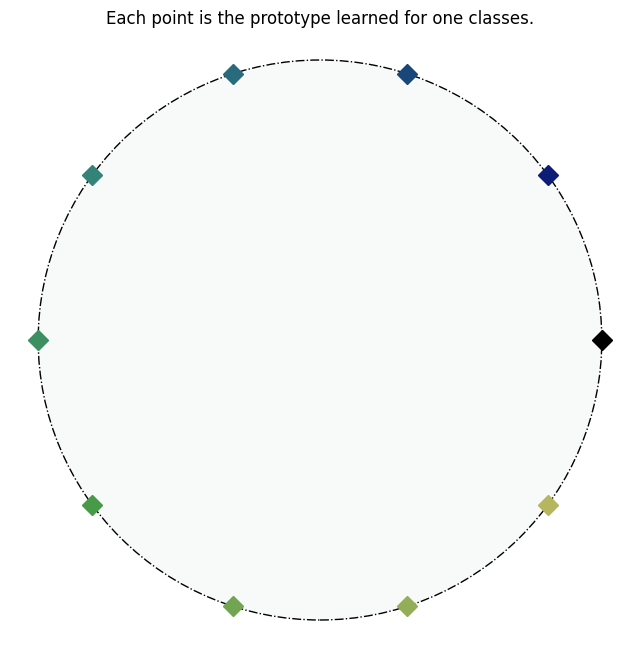

In [5]:
if dims == 2:

    cmap = plt.get_cmap('gist_earth')
    colors_list = [cmap(i) for i in np.linspace(0, 1, num_classes + 4)]

    matplotlib.pyplot.figure(figsize=(8, 8))
    ax = plt.gca()

    for i in range(num_classes):
        plt.plot(prototypes[i, 0].detach().numpy(), prototypes[i, 1].detach().numpy(), markersize = 10,  marker = 'D', linestyle='none', color = colors_list[i])

    ax.add_patch(plt.Circle((0, 0), 1, fill=True, ec='black', fc='#f8f9f9', linestyle='-.', linewidth=1, zorder=0))

    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')

    ax.tick_params(
        axis='both',   # changes apply to the x-axis
        which='both',  # both major and minor ticks are affected
        bottom=False,  # ticks along the bottom edge are off
        top=False,     # ticks along the top edge are off
        left=False,
        labelbottom=False)

    # Turn off tick labels
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.title('Each point is the prototype learned for one classes.')
    plt.show()

Throught this tutorial, we will perform prototype learning using the Ideal prototypes. To this end, `CIFAR10` dataset is selected.

The first step is downloading and loading the dataset and dataloader.

In [6]:
## Path to save the data 
basedir = '.'

## batch size needed to define the dataloader
batch_size = 128

In [7]:
mrgb = [0.507, 0.487, 0.441]
srgb = [0.267, 0.256, 0.276]


kwargs = {'num_workers': 32, 'pin_memory': True}
normalize = transforms.Normalize(mean=mrgb, std=srgb)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Training Dataset
train_dataset = datasets.CIFAR10(root=basedir + 'cifar10/', train=True,
                                 transform=transforms.Compose([transforms.RandomCrop(32, 4),
                                                               transforms.RandomHorizontalFlip(),
                                                               transforms.ToTensor(),
                                                               normalize,
                                                               ]), download=True)
trainloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True, **kwargs)
trainloader.dataset.train_labels = torch.from_numpy(np.array(trainloader.dataset.targets))

# Testing Dataset
test_dataset = datasets.CIFAR10(root=basedir + 'cifar10/', train=False,
                                transform=transforms.Compose([transforms.ToTensor(),normalize,]))
testloader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, shuffle=True, **kwargs)
testloader.dataset.test_labels = torch.from_numpy(np.array(testloader.dataset.targets))

100.0%


Extracting .cifar10/cifar-10-python.tar.gz to .cifar10/


Before starting the main task, let's check how images from the dataset look like.

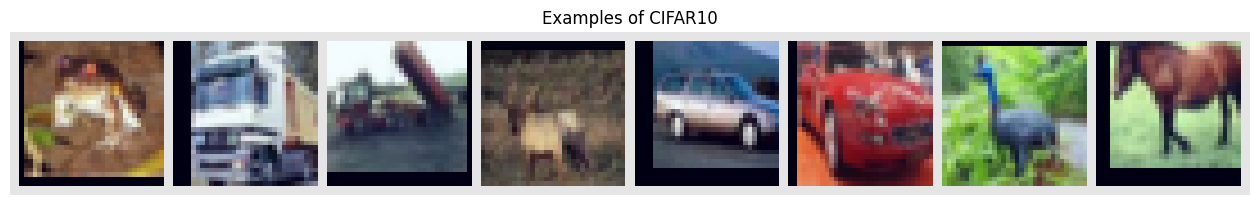

  frog          truck         truck         deer          car           car           bird          horse        


In [8]:
NUM_IMAGES = 8
images = [train_dataset[idx][0] for idx in range(NUM_IMAGES)]
labels = [train_dataset.targets[idx] for idx in range(NUM_IMAGES)]

img_grid = torchvision.utils.make_grid(images, nrow=8, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(16,8))
plt.title("Examples of CIFAR10")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()
print('  ' + ' '.join(f'{classes[labels[j]]:13s}' for j in range(NUM_IMAGES)))

## Hyperbolic Image Classification using Ideal prototypes

The goal of hyperbolic Busemann learning with Ideal prototypes is to learn hyperbolic representations for the given data close to the corresponding ideal prototype. Initially, a Euclidean model, i.e., `ResNet`, is used to extract Euclidean representations. Then, the Euclidean representations are projected to the Hyperbolic space using `Exponential Map`.

Once the hyperbolic representations are ready, it's time to calculate the distance to the corresponding Ideal prototype and minimize it. Since the prototypes are on the ideal boundary of hyperbolic space, the Poincare distance results in infinity and cannot be calculated. Therefore, `Penalized Busemann Loss` is proposed in the paper.

Given `p` as the prototype and `z` as the hyperbolic data representation,  `Busemann function` and `Penalized Busemann Loss` are calculated using $b_p(z)$ and $\ell(z, p)$,

\begin{align}
b_p(z) = \log \frac{||p - z||^2}{(1 - ||z||^2)}
\end{align}

\begin{align}
\ell(z, p) = b_p(z) - \phi(d) \cdot \log(1 - ||z||^2),
\end{align}

with $\phi(d)$ a scaling factor for the penalty term which is a function of the dimension of the hyperbolic space. In the penalized Busemann loss, $\phi(d)$ governs the amount of regularization. The paper shows that this
function should be linear in the number of dimensions. Therefore, $\phi(d)$ is defined as $s.d$, which $s$ is named as `mult` in the code.

In [9]:
# Hyperbolic hyperparameters
c = 1.0
mult = 0.75

In [10]:
class PeBusePenalty(nn.Module):
    def __init__(self, dimension, mult=1.0):
        super(PeBusePenalty, self).__init__()
        self.dimension = dimension
        self.penalty_constant = mult * self.dimension

    def forward(self, p, g):
        # first part of loss
        prediction_difference = g - p
        difference_norm = torch.norm(prediction_difference, dim=1)
        difference_log = 2 * torch.log(difference_norm)

        # second part of loss
        data_norm = torch.norm(p, dim=1)
        proto_difference = (1 - data_norm.pow(2) + 1e-6)
        proto_log = (1 + self.penalty_constant) * torch.log(proto_difference)

        # second part of loss
        constant_loss = self.penalty_constant * math.log(2)

        one_loss = difference_log - proto_log + constant_loss
        total_loss = torch.mean(one_loss)

        return total_loss

The `dims` used here is the prototype and output dimensions, initialized when learning prototypes.

In [11]:
f_loss = PeBusePenalty(dims, mult)

Let's first initialize hyperparamers and optimizers.

In [12]:
# General hyperparameters
learning_rate = 0.0005
decay = 0.00005
epochs = 100
drop1 = 1000
drop2 = 1100
do_decay = True

`ResNet32` is initialized and used to extract Euclidean representations of the input data.

In [13]:
model = resnet.ResNet(32, dims, 1, prototypes.float())
model = model.to(device)

In [14]:
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay)

Now, everything is ready to start training.

In [15]:
manifold = geoopt.PoincareBall(c=c)
print('Training started:')
for i in range(epochs):
    # Learning rate decay.
    if i in [drop1, drop2] and do_decay:
        learning_rate *= 0.1
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    avg_loss = 0
    sum_loss = 0
    count = 0
    acc = 0
    model.train()
    for bidx, (data, target) in enumerate(trainloader):
        target_tmp = target.to(device)
        target = model.polars[target]
        
        data = torch.autograd.Variable(data).to(device)
        target = torch.autograd.Variable(target).to(device)

        output = model(data)
        output_exp_map = manifold.expmap0(output)

        loss_func = f_loss(output_exp_map, target)


        optimizer.zero_grad()
        loss_func.backward()
        optimizer.step()

        sum_loss += loss_func.item()
        count += 1.

        output = model.predict(output_exp_map).float()
        pred = output.max(1, keepdim=True)[1]
        acc += pred.eq(target_tmp.view_as(pred)).sum().item()

    avg_loss = sum_loss / float(len(trainloader.dataset))
    avg_acc = acc / float(len(trainloader.dataset))
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    if i != 0 and (i % 10 == 0 or i == epochs - 1):
        valid_acc = 0
        valid_loss = 0
        model.eval()
        with torch.no_grad():
            for data_val, target_val in testloader:
                data_val = torch.autograd.Variable(data_val).to(device)
                target_val = torch.autograd.Variable(target_val).to(device)
                target_loss_val = model.polars[target_val]

                output_val = model(data_val).float()
                output_val_exp_map = manifold.expmap0(output_val)

                output_val = model.predict(output_val_exp_map).float()
                pred_val = output_val.max(1, keepdim=True)[1]
                valid_acc += pred_val.eq(target_val.view_as(pred_val)).sum().item()

                valid_loss += f_loss(output_val_exp_map, target_loss_val.to(device)).item()
            
        len_test = len(testloader.dataset)

        valid_avg_acc = valid_acc / float(len_test)
        valid_avg_loss = valid_loss / float(len_test)
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        print('Epoch '+str(i)+' :' )
        print('Training Loss:' + str(avg_loss)+' , Training Accuracy: '+str(avg_acc))
        print('Val Loss:' + str(valid_avg_loss)+' , Val Accuracy: '+str(valid_avg_acc)) 

Training started:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 10 :
Training Loss:0.004980027570724487 , Training Accuracy: 0.64096
Val Loss:0.005297535902261734 , Val Accuracy: 0.6272
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 20 :
Training Loss:0.004105883414745331 , Training Accuracy: 0.78252
Val Loss:0.004605498462915421 , Val Accuracy: 0.7443
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 30 :
Training Loss:0.0037260478436946867 , Training Accuracy: 0.83498
Val Loss:0.004251863679289818 , Val Accuracy: 0.7945
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 40 :
Training Loss:0.003505309413075447 , Training Accuracy: 0.86814
Val Loss:0.0040145975530147555 , Val Accuracy: 0.8232
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 50 :
Training Loss:0.0033344823771715164 , Training Accuracy: 0.88842
Val Loss:0.003981673476099968 , Val Accura

Let's visualize the output space.

In [16]:
output_vectors = []
gt_labels = []

model.eval()
with torch.no_grad():
    for data_val, target_val in testloader:
        data_val = torch.autograd.Variable(data_val).to(device)
        target_val = torch.autograd.Variable(target_val).to(device)
        target_loss_val = model.polars[target_val]

        output_val = model(data_val).float()
        output_val_exp_map = manifold.expmap0(output_val)

        output_vectors.extend(output_val_exp_map.cpu().numpy().tolist())
        gt_labels.extend(target_val.cpu().numpy().tolist())
    
output_vectors = np.array(output_vectors)
gt_labels = np.array(gt_labels).reshape(-1, 1)
# Let's select a subset of the data!
subset_index = np.random.choice(np.array(range(0,gt_labels.shape[0])), 1000, replace=False)

output_vectors_small = output_vectors[subset_index, :]
gt_labels_small = gt_labels[subset_index]

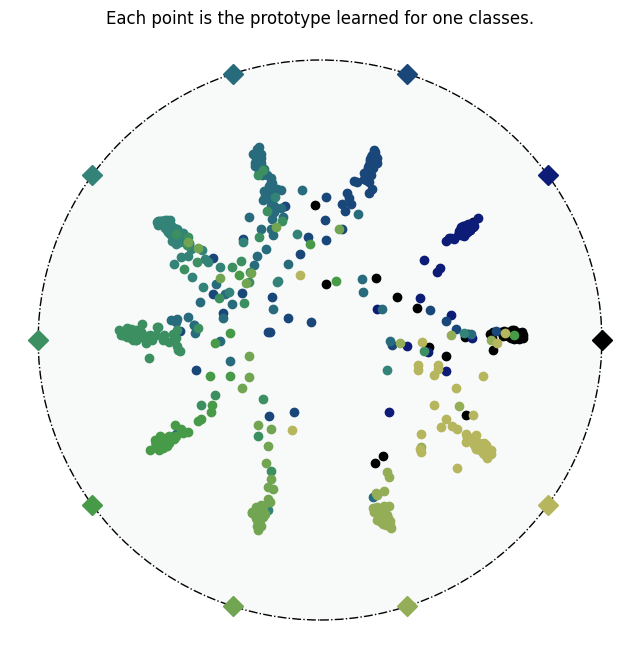

In [17]:
cmap = plt.get_cmap('gist_earth')
colors_list = [cmap(i) for i in np.linspace(0, 1, num_classes + 4)]

if dims == 2:
    matplotlib.pyplot.figure(figsize=(8, 8))
    ax = plt.gca()

    for i in range(num_classes):
        plt.plot(prototypes[i, 0].detach().numpy(), prototypes[i, 1].detach().numpy(), markersize = 10,  marker = 'D', linestyle='none', color = colors_list[i])

        output_vectors_small_i = output_vectors_small[np.where(gt_labels_small == i)[0], :]
        ax.scatter(output_vectors_small_i[:, 0], output_vectors_small_i[:, 1], color = colors_list[i])

    ax.add_patch(plt.Circle((0, 0), 1, fill=True, ec='black', fc='#f8f9f9', linestyle='-.', linewidth=1, zorder=0))

    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')

    ax.tick_params(
        axis='both',   # changes apply to the x-axis
        which='both',  # both major and minor ticks are affected
        bottom=False,  # ticks along the bottom edge are off
        top=False,     # ticks along the top edge are off
        left=False,
        labelbottom=False)

    # Turn off tick labels
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.title('Each point is the prototype learned for one classes.')
    plt.show()